# Physical Activty Prediction
## 1. Introduction 

In the final project for the edx-course "Python for Research" tri-axial smartphone accelerometer data were used to predict the type of physical activity (e.g., standing, walking, upstairs and downstais movement). The dataset consists of 4 files: Two files fo training, two files for testing. While there are test and training data for $x$, $y$ and $z$ in the resultion of 0.1 seconds, the labels are only provided (test) and to be found (train), respectively, for every 10$^{th}$ value, i.e. every second. 

The activity labels, i.e.  1 = standing, 2 = walking, 3 = downstairs, 4 = upstairs, corresponding to $x$, $y$ and $z$-acceleration data, are the outcomes to be found in the following classification. After inspection and a slight filtering, the covariates for the classification are defined, using the mean, maximum etc. of a specific time window around the index of interest of the acceleration data. 

Several regressors and classifiers were tested. In this approach, the RandomForestClassifier resulted in the highest accuracy. After classification, a post pocessing of the label-list was performed, which takes the majority vote of neighbor labels into account.


## 2. Methods: 

In this approach, I used a light lowpass filter (butter), in order to reduce high frequency noise. The covariates for the classification were produced from moving window calculation, i.e. pandas rolling, in order to find averaged covariates over time. The window approach, and an averaging over time, seems reasonabel, as only every 10$^{th}$ label value is provided or to be found. Also, this further reduces the noise. The drawback, nevertheless is that this approach leads to more uncertainties at the edges, i.e. where the label changes between two activity modes. After this rolling process, I kept only the rows with labels (or for which labels have to be found, respectively).

For the classification, I found the random forest classifier to perform best for my approach. I also tried other classifiers as introduced throughout the course and additionally, the svc classifier, but they led to less accuracy fo my test data, which I split for testing. In the appendix I also show a method I found to optimize and check the parameters used for the random forest classifier.  

The plots of the results for the training data were very promising: I reached 100% accuracy. The trick was, not to set a limit for the depth of the classifier, i.e. not specifying this parameter for the classifier. Nevertheless, the split off test data, have less than 100 % accuracy. The test data, which's labels should be classified in this work showed a clear picture, nevertheless, I decided to make a post-processing, to take the value of the neighbouring labels into account. 

Hence, in the results part, following outline and pocedure is used:
## 3. Results
- 3.1 Peparing and inspecting data
    * 3.1.1 Import libraries, 
    * 3.1.2 Import test-data and train data. 
    - 3.1.3 Plot data to find specific features
    - 3.1.4 Preprocessing with a lowpass filter
- 3.2 Preparing for classification
    - 3.2.1 Calculate and define covariates
    - 3.2.2 Keep only rows with label (to be determined)
- 3.3. Classification
    - 3.3.1 Split test data into "test and train data" to check accuracy
    - 3.3.2 Define classifier and covariates to be used (avoid over- and underfitting)
    - 3.3.3 Fit the classifier and plot check accuracy
    - 3.3.5 Final processing and save
               
              

### 3.1.1 Library Import 
First import libraries needed: 
- pandas, numpy and matplotlib.pyplot, of course. 
- For preprocessing with a bandpass filter, scipy is needed.
- for finding 0-crossings of the first derivative (maxima), I used scipy as well
- Random Forest Classifier and train_test_split 

In [1743]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

from scipy import signal # for lowpass filter
from scipy.interpolate import UnivariateSpline #for finding zeroes in derivative

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 2.1.2 Import Input Data

The input data used for training in this project consists of two files. The first file, "train_time_series.csv", contains the raw accelerometer data and it has the format:

*timestamp, UTC time, accuracy, x, y, z*

*x, y,* and *z*, correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, train_labels.csv, contains the activity labels, to train the model. The labels in train_labels.csv are provided for every 10$^{th}$ observation in train_time_series.csv.

For the test data we have the same file structure, except that no labels are povided.

Read the data into pandas-Dataframes: 
- train_labels.csv and train_time_series.csv into df
- test_labels.csv and test_time_series.csv into df2

Also, calculate the magnitude $m=\sqrt{x^2+y^2+z^2}$ and add it as an additional row in df and df2.

In [1782]:
# change to the directory, where the files are stored

%cd "C:\Users\Dokuments\Python\final project\" 


# reading the data

# train data
ttseries=pd.read_csv("train_time_series.csv", low_memory=False, index_col=0)
tlabels=pd.read_csv("train_labels.csv", low_memory=False, index_col=0)

# store train data in df
df=ttseries

# I want to have the labels in the df-Dataframe. As train_labels.csv has reduced data I make
# a new array of len(df) for train labels, first
an_array = np.empty((len(df),1))
an_array[:] = np.NaN
# append this array of NaNs to df in the column "label"
df['label']=an_array
# write the known labels from train_labels.csv into this column at the specified indices
df.loc[tlabels.index,"label"]=tlabels
# calculate the magnitude m= sqrt(x^2+y^2+z^2) and store as m in df
df["m"]=np.sqrt((np.array(df.x))**2+(np.array(df.y))**2+(np.array(df.z))**2)



# store test data in df2, basically same as above, except there are no labels provided
tetseries=pd.read_csv("test_time_series.csv", low_memory=False, index_col=0)
telabels=pd.read_csv("test_labels.csv", low_memory=False, index_col=0)
df2=tetseries
#df2['Datetime'] = pd.to_datetime(np.array(df2['UTC time']))
df2["m"]=np.sqrt((np.array(df2.x))**2+(np.array(df2.y))**2+(np.array(df2.z))**2)
# as telabels includes no labels, there is no need to append a "label"-column for now

### 3.1.3 Plot raw data 

- Plot the raw data for the test series and the corresponding labels
- Plot a smaller time window fo each activity label

Text(0.5, 0, 'Index')

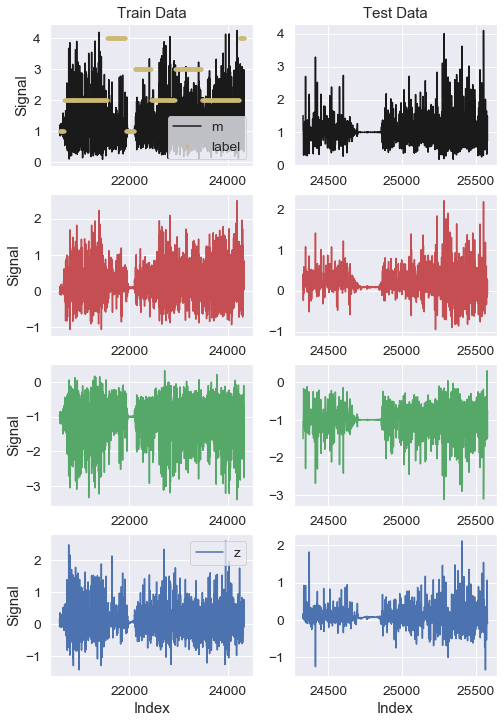

In [1745]:
#fig = plt.figure()
plt.figure(figsize=(8,12))
plt.subplot(4, 2, 1)
plt.title("Train Data")
plt.plot(df.m,'k-', label="m")
plt.plot(tlabels.label,'y.', label="label")
plt.legend(loc="lower right")
plt.ylabel("Signal")
plt.subplot(4, 2, 3)
plt.plot(df.x,'r-', label="x")
plt.ylabel("Signal")
plt.subplot(4, 2, 5)
plt.plot(df.y,'g-',label="y")
plt.ylabel("Signal")
plt.subplot(4, 2, 7)
plt.plot(df.z,'b-',label="z")
plt.legend(loc="best")
plt.ylabel("Signal")
plt.xlabel("Index")

# test data
plt.subplot(4, 2, 2)
#plt.plot(telabels.label,'g',linewidth=1)
plt.plot(df2.m,'k-')
plt.title("Test Data")
plt.subplot(4, 2, 4)
plt.plot(df2.x,'r-')
plt.subplot(4, 2, 6)
plt.plot(df2.y,'g-')
plt.subplot(4, 2, 8)
plt.plot(df2.z,'b-')
plt.xlabel("Index")

Conclusion fom the upper plot: 
- left side (train-data): The standing periods (label=1) seem to be straightforwad to interpret. From looking at the peak height or min-to-max-difference, there is no clear indication, which activity mode (2,3,4) is present. 
- right side (test-data): There should be a standing period as well aound index 24750.

In order to display activity features in more details, they will be plotted for a smaller time intervall, i.e. indices (1 index-point equals 0.1 seconds).
- First the start and end indices of the activity mode will be determined using the function findindex.
- Than, each activity mode will be plotted roughly in the middle of its occurence for a certain timewindow (timewindow=60, i.e. 6 seconds), which can be specified.
- 16 plots will be produced

Text(0.5, 0, 'Index')

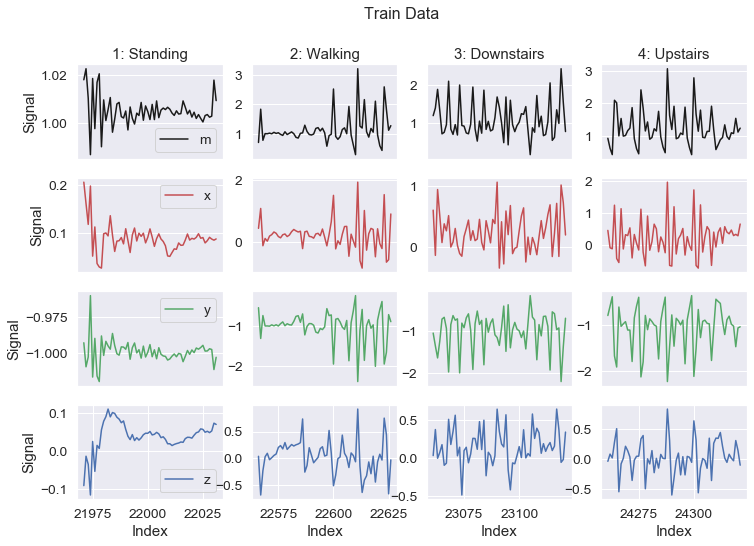

In [1746]:
# plotting the raw data for 4 different activity modes

# first: find start and stop indices for different acticity labels, this can be used for cuttung the edges later, as well

def findindex(label=1):
    ''' look for index-slices (start and end-index) for each activity mode with label = 1 to 4'''
    a=list(df[df.label==label].index) # make a list for indices of specific label
    slice=[] 
    slice.append(a[0]) # first, append the start-index
    for i in range(len(a)-1):
        if a[i]+10<a[i+1]: # if the diffence between a[i] and a[i+1] is larger than 10... could also be handled with diff()>10
            slice.append(a[i]) # append the end index of the first slice
            slice.append(a[i+1]) # and diectly after the start index of the last slide
    slice.append(a[-1]) # finally, append the last index with this label
    return slice
            
#calculate begin and end-indeces for label 1,2,3,4
be1=findindex(label=1)
be2=findindex(label=2)
be3=findindex(label=3)
be4=findindex(label=4)

# now choose a timewindow, the distance between indices is 0.1 sec
timewindow=60 # in indices, i.e. 6 seconds
# plotting start at 1/4 of the length of the second slice, end: +timewindow
plt.figure(figsize=(12,8))
#plt.title("Train Data")
plt.suptitle("Train Data", fontsize=16)
plt.subplot(4, 4, 1)
plt.title("1: Standing")
#plt.plot(tlabels.label,'g',linewidth=1)
plt.plot(df.m.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)],'k-',label="m")
plt.legend(loc="best")
plt.ylabel("Signal")
plt.xticks([])

plt.subplot(4, 4, 5)
plt.plot(df.x.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'r-',label="x")
plt.ylabel("Signal")
plt.legend(loc="best")
plt.xticks([])

plt.subplot(4, 4, 9)
plt.plot(df.y.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'g-',label="y")
plt.ylabel("Signal")
plt.legend(loc="best")
plt.xticks([])

plt.subplot(4, 4, 13)
plt.plot(df.z.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'b-',label="z")
plt.legend(loc="best")
plt.xlabel("Index")
plt.ylabel("Signal")



plt.subplot(4, 4, 2)
plt.title("2: Walking")
#plt.plot(tlabels.label,'g',linewidth=1)
plt.plot(df.m.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)],'k-')
plt.xticks([])

plt.subplot(4, 4, 6)
plt.plot(df.x.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)]
,'r-')
plt.xticks([])

plt.subplot(4, 4, 10)
plt.plot(df.y.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)]
,'g-')
plt.xticks([])

plt.subplot(4, 4, 14)
plt.plot(df.z.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)],'b-')
plt.xlabel("Index")


plt.subplot(4, 4, 3)
#plt.plot(tlabels.label,'g',linewidth=1)
plt.title("3: Downstairs")
plt.plot(df.m.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'k-')
plt.xticks([])

plt.subplot(4, 4, 7)
plt.plot(df.x.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'r-')
plt.xticks([])

plt.subplot(4, 4, 11)
plt.plot(df.y.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'g-')
plt.xticks([])

plt.subplot(4, 4, 15)
plt.plot(df.z.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'b-')
plt.xlabel("Index")


plt.subplot(4, 4, 4)
#plt.plot(tlabels.label,'g',linewidth=1)
plt.title("4: Upstairs")

plt.plot(df.m.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'k-')
plt.xticks([])

plt.subplot(4, 4, 8)
plt.plot(df.x.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'r-')
plt.xticks([])

plt.subplot(4, 4, 12)
plt.plot(df.y.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'g-')
plt.xticks([])

plt.subplot(4, 4, 16)
plt.plot(df.z.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'b-')
plt.xlabel("Index")

Conclusions from the upper plot for test data (df): The moving patterns seem to be slightly different. Especially upstairs walking seems to have a different appearance. Hence counting the number of maxima in a specific time window (or the mean time between maxima) could be taken as a covariate.

### 3.1.4 Peprocessing
- Apply a slight lowpass filter signal.butter() in order to remove high frequency noise
- Cutoff is the paameter to play with: the lower, the more drastic are the effects on the data.
- First apply the filter to the test data (df) an plot it. 
- Caution: After the next step, the raw data will be removed by the filtered ones.
- In the next plot, filtered data will be drawn and can be compared to the plot of the raw data above.

In [1747]:
# apply lowpass- filter to m,x,y,z

# the data need to be passed to the filter as a np.array
m=np.array(df['m'])
x=np.array(df['x'])
y=np.array(df['y'])
z=np.array(df['z'])
#tdata=np.array(df['Datetime'])#[0]


#fig = plt.figure()
#plt.figure(figsize=(8,12))
#plt.subplot(4, 2, 1)
#plt.plot(tlabels.label,'g',linewidth=1)
#plt.plot(df.m,'k-')
#plt.subplot(4, 2, 3)
#plt.plot(df.x[df.index[200:400]],'k-')
#plt.subplot(4, 2, 5)
#plt.plot(df.y,'k-')
#plt.subplot(4, 2, 7)
#plt.plot(df.z,'k-')

def lowpass(data,fs=10, cutoff=0.79):
    ## Filtering of the time series
    #fs=10 # in Hz (sampling frequency)
    nyquist = fs / 2 # 0.5 times the sampling frequency
    #cutoff # fraction of nyquist frequency
#    print('cutoff= ', 1/cutoff*nyquist,'Hz') #
    b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter
    dfilt = signal.filtfilt(b, a, data)
    dfilt=np.array(dfilt)
    dfilt=dfilt.transpose()
    return dfilt

#plt.figure(figsize=(8,12))
# now apply the filter to m,x,y,z
df['m']=lowpass(m)
df['x']=lowpass(x)
df['y']=lowpass(y)
df['z']=lowpass(z)

Text(0.5, 0, 'Index')

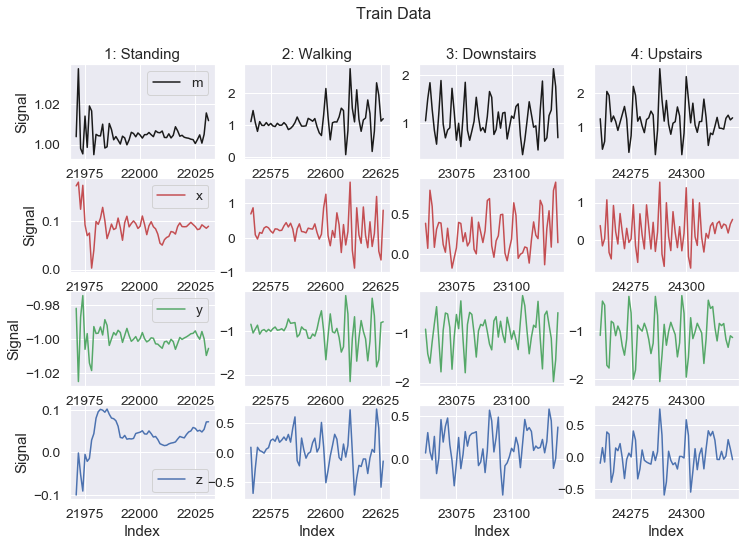

In [1748]:

plt.figure(figsize=(12,8))

plt.subplot(4, 4, 1)
plt.suptitle("Train Data", fontsize=16)

plt.title("1: Standing")
#plt.plot(tlabels.label,'g',linewidth=1)
plt.plot(df.m.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)],'k-',label="m")
plt.legend(loc="best")
plt.ylabel("Signal")
plt.subplot(4, 4, 5)
plt.plot(df.x.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'r-',label="x")
plt.ylabel("Signal")
plt.legend(loc="best")
plt.subplot(4, 4, 9)
plt.plot(df.y.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'g-',label="y")
plt.ylabel("Signal")
plt.legend(loc="best")

plt.subplot(4, 4, 13)
plt.plot(df.z.loc[int((be1[3]-be1[2])/4+be1[2]):int((be1[3]-be1[2])/4+be1[2]+timewindow)]
,'b-',label="z")
plt.legend(loc="best")
plt.xlabel("Index")
plt.ylabel("Signal")



plt.subplot(4, 4, 2)
plt.title("2: Walking")
#plt.plot(tlabels.label,'g',linewidth=1)
plt.plot(df.m.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)],'k-')
plt.subplot(4, 4, 6)
plt.plot(df.x.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)]
,'r-')
plt.subplot(4, 4, 10)
plt.plot(df.y.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)]
,'g-')
plt.subplot(4, 4, 14)
plt.plot(df.z.loc[int((be2[3]-be2[2])/4+be2[2]):int((be2[3]-be2[2])/4+be2[2]+timewindow)],'b-')
plt.xlabel("Index")


plt.subplot(4, 4, 3)
#plt.plot(tlabels.label,'g',linewidth=1)
plt.title("3: Downstairs")

plt.plot(df.m.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'k-')
plt.subplot(4, 4, 7)
plt.plot(df.x.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'r-')
plt.subplot(4, 4, 11)
plt.plot(df.y.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'g-')
plt.subplot(4, 4, 15)
plt.plot(df.z.loc[int((be3[3]-be3[2])/4+be3[2]):int((be3[3]-be3[2])/4+be3[2]+timewindow)]
,'b-')
plt.xlabel("Index")


plt.subplot(4, 4, 4)
#plt.plot(tlabels.label,'g',linewidth=1)
plt.title("4: Upstairs")

plt.plot(df.m.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'k-')
plt.subplot(4, 4, 8)
plt.plot(df.x.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'r-')
plt.subplot(4, 4, 12)
plt.plot(df.y.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'g-')
plt.subplot(4, 4, 16)
plt.plot(df.z.loc[int((be4[3]-be4[2])/4+be4[2]):int((be4[3]-be4[2])/4+be4[2]+timewindow)]
,'b-')
plt.xlabel("Index")

Conclusion from above plot: Only slight changes to the original data have been made. It turned out that for the following procedure, these slight changes are slightly helpful for the accuracy of the classifiers. Whereas the classification would not benefit from a lower cutoff (i.e. more drastic filering).

Now apply the same lowpassfilter to df2 (test-data) and plot the raw and filtered data. Note: label-indices are unknown.

Text(0.5, 0, 'Index')

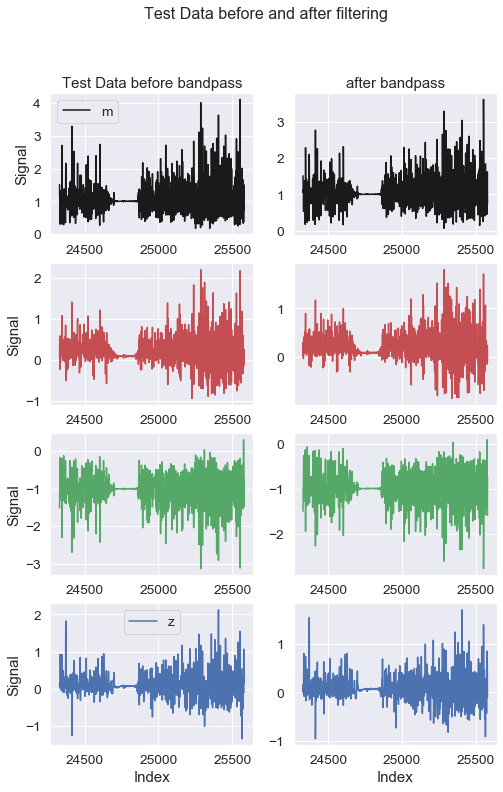

In [1749]:
# apply the same lowpassfilter to df2 (test-data)
# note: label-indices are unknown
m=np.array(df2['m'])
x=np.array(df2['x'])
y=np.array(df2['y'])
z=np.array(df2['z'])
#tdata=np.array(df2['Datetime'])#[0]


#fig = plt.figure()
plt.figure(figsize=(8,12))
plt.suptitle("Test Data before and after filtering", fontsize=16)

plt.subplot(4, 2, 1)
plt.plot(telabels.label,'g',linewidth=1)
plt.title("Test Data before bandpass")
plt.plot(df2.m,'k-', label="m")
plt.legend(loc="best")
plt.ylabel("Signal")
plt.subplot(4, 2, 3)
plt.plot(df2.x,'r-', label="x")
plt.ylabel("Signal")
plt.subplot(4, 2, 5)
plt.plot(df2.y,'g-',label="y")
plt.ylabel("Signal")
plt.subplot(4, 2, 7)
plt.plot(df2.z,'b-',label="z")
plt.legend(loc="best")
plt.ylabel("Signal")
plt.xlabel("Index")


df2['m']=lowpass(m)
df2['x']=lowpass(x)
df2['y']=lowpass(y)
df2['z']=lowpass(z)

plt.subplot(4, 2, 2)
#plt.plot(telabels.label,'g',linewidth=1)
plt.plot(df2.m,'k-')
plt.title("after bandpass")
plt.subplot(4, 2, 4)
plt.plot(df2.x,'r-')
plt.subplot(4, 2, 6)
plt.plot(df2.y,'g-')
plt.subplot(4, 2, 8)
plt.plot(df2.z,'b-')
plt.xlabel("Index")


Conclusions from plot above: Only slight changes have been made fom raw (left) to filtered (right) data. In this pesentation, only a slight change in the min and max values of the peaks is visible. As mentioned above, the filtering did not have a major effect on the accuracy of classification. But still, the used parameters led to a few percent points of more accuracy, which is why I decided proceed with filtered data.

## 3.2. Preparing for Classification  
### 3.2.1 Defining covariates

As the activity labels are only provided for every 10th point, rolling for pandas dataframes was used (similar to the moving window average we defined in one of our homeworks), to define mean, std, var, median, min, max, peak-to-peak (ptop), sharp, skew, and sum for a specific timewindow n. It turned out during my tests, that a unexpectedly large n of 35 gives best classification accuracies.

The procedue is exemplarily descibed for one calculation:

df.loc[tlabels.index,"mean_m"]=df.m.rolling(n,min_periods=0,center=True).mean().loc[tlabels.index]

- tlabels.index: the calculation is only done for rows, where a index value (label) is provided
- "mean_m": the name of the new column in df
- rolling: similar to moving window
- n: the index-window
- min-periods: this is how NaNs at start and end can be avoided, although the window becomes smaller
- center=True: the resulting value is assigned to this index
- finally, the calculation to be done in this step: mean()
- tlabels.index: as above

In [1750]:
n=35

df.loc[tlabels.index,"mean_x"]=df.x.rolling(n,min_periods=0,center=True).mean().loc[tlabels.index]
df.loc[tlabels.index,"mean_y"]=df.y.rolling(n,min_periods=0,center=True).mean().loc[tlabels.index]
df.loc[tlabels.index,"mean_z"]=df.z.rolling(n,min_periods=0,center=True).mean().loc[tlabels.index]


df.loc[tlabels.index,"std_x"]=df.x.rolling(n,min_periods=0,center=True).std().loc[tlabels.index]
df.loc[tlabels.index,"std_y"]=df.y.rolling(n,min_periods=0,center=True).std().loc[tlabels.index]
df.loc[tlabels.index,"std_z"]=df.z.rolling(n,min_periods=0,center=True).std().loc[tlabels.index]

df.loc[tlabels.index,"var_x"]=df.x.rolling(n,min_periods=0,center=True).var().loc[tlabels.index]
df.loc[tlabels.index,"var_y"]=df.y.rolling(n,min_periods=0,center=True).var().loc[tlabels.index]
df.loc[tlabels.index,"var_z"]=df.z.rolling(n,min_periods=0,center=True).var().loc[tlabels.index]

df.loc[tlabels.index,"median_x"]=df.x.rolling(n,center=True,min_periods=0).median().loc[tlabels.index]
df.loc[tlabels.index,"median_y"]=df.y.rolling(n,center=True,min_periods=0).median().loc[tlabels.index]
df.loc[tlabels.index,"median_z"]=df.z.rolling(n,center=True,min_periods=0).median().loc[tlabels.index]

df.loc[tlabels.index,"min_x"]=df.x.rolling(n,center=True,min_periods=0).min().loc[tlabels.index]
df.loc[tlabels.index,"min_y"]=df.y.rolling(n,center=True,min_periods=0).min().loc[tlabels.index]
df.loc[tlabels.index,"min_z"]=df.z.rolling(n,center=True,min_periods=0).min().loc[tlabels.index]

df.loc[tlabels.index,"max_x"]=df.x.rolling(n,center=True,min_periods=0).max().loc[tlabels.index]
df.loc[tlabels.index,"max_y"]=df.y.rolling(n,center=True,min_periods=0).max().loc[tlabels.index]
df.loc[tlabels.index,"max_z"]=df.z.rolling(n,center=True,min_periods=0).max().loc[tlabels.index]

df.loc[tlabels.index,"skew_x"]=df.x.rolling(n,center=True,min_periods=0).skew().loc[tlabels.index]
df.loc[tlabels.index,"skew_y"]=df.y.rolling(n,center=True,min_periods=0).skew().loc[tlabels.index]
df.loc[tlabels.index,"skew_z"]=df.z.rolling(n,center=True,min_periods=0).skew().loc[tlabels.index]

df.loc[tlabels.index,"sum_x"]=df.x.rolling(n,center=True,min_periods=0).sum().loc[tlabels.index]
df.loc[tlabels.index,"sum_y"]=df.y.rolling(n,center=True,min_periods=0).sum().loc[tlabels.index]
df.loc[tlabels.index,"sum_z"]=df.z.rolling(n,center=True,min_periods=0).sum().loc[tlabels.index]


df.loc[tlabels.index,"ptop_x"]=df.max_x.loc[tlabels.index]-df.min_x.loc[tlabels.index]
df.loc[tlabels.index,"ptop_y"]=df.max_y.loc[tlabels.index]-df.min_y.loc[tlabels.index]
df.loc[tlabels.index,"ptop_z"]=df.max_z.loc[tlabels.index]-df.min_z.loc[tlabels.index]

df.loc[tlabels.index,"sharp_x"]=df.mean_x.loc[tlabels.index]/df.std_x.loc[tlabels.index]
df.loc[tlabels.index,"sharp_y"]=df.mean_y.loc[tlabels.index]/df.std_y.loc[tlabels.index]
df.loc[tlabels.index,"sharp_z"]=df.mean_z.loc[tlabels.index]/df.std_z.loc[tlabels.index]


Now the same for df2 (i.e. test data), where we have the indices, but not the labels, yet

In [1751]:
n=35
df2.loc[telabels.index,"mean_x"]=df2.x.rolling(n, min_periods=0,center=True).mean().loc[telabels.index]
df2.loc[telabels.index,"mean_y"]=df2.y.rolling(n,min_periods=0,center=True).mean().loc[telabels.index]
df2.loc[telabels.index,"mean_z"]=df2.z.rolling(n,min_periods=0,center=True).mean().loc[telabels.index]

df2.loc[telabels.index,"std_x"]=df2.x.rolling(n,min_periods=0,center=True).std().loc[telabels.index]
df2.loc[telabels.index,"std_y"]=df2.y.rolling(n,min_periods=0,center=True).std().loc[telabels.index]
df2.loc[telabels.index,"std_z"]=df2.z.rolling(n,min_periods=0,center=True).std().loc[telabels.index]

df2.loc[telabels.index,"var_x"]=df2.x.rolling(n,min_periods=0,center=True).var().loc[telabels.index]
df2.loc[telabels.index,"var_y"]=df2.y.rolling(n,min_periods=0,center=True).var().loc[telabels.index]
df2.loc[telabels.index,"var_z"]=df2.z.rolling(n,min_periods=0,center=True).var().loc[telabels.index]

df2.loc[telabels.index,"median_x"]=df2.x.rolling(n,center=True,min_periods=0).median().loc[telabels.index]
df2.loc[telabels.index,"median_y"]=df2.y.rolling(n,center=True,min_periods=0).median().loc[telabels.index]
df2.loc[telabels.index,"median_z"]=df2.z.rolling(n,center=True,min_periods=0).median().loc[telabels.index]

df2.loc[telabels.index,"min_x"]=df2.x.rolling(n,center=True,min_periods=0).min().loc[telabels.index]
df2.loc[telabels.index,"min_y"]=df2.y.rolling(n,center=True,min_periods=0).min().loc[telabels.index]
df2.loc[telabels.index,"min_z"]=df2.z.rolling(n,center=True,min_periods=0).min().loc[telabels.index]

df2.loc[telabels.index,"max_x"]=df2.x.rolling(n,center=True,min_periods=0).max().loc[telabels.index]
df2.loc[telabels.index,"max_y"]=df2.y.rolling(n,center=True,min_periods=0).max().loc[telabels.index]
df2.loc[telabels.index,"max_z"]=df2.z.rolling(n,center=True,min_periods=0).max().loc[telabels.index]

df2.loc[telabels.index,"sum_x"]=df2.x.rolling(n,center=True,min_periods=0).sum().loc[telabels.index]
df2.loc[telabels.index,"sum_y"]=df2.y.rolling(n,center=True,min_periods=0).sum().loc[telabels.index]
df2.loc[telabels.index,"sum_z"]=df2.z.rolling(n,center=True,min_periods=0).sum().loc[telabels.index]


df2.loc[telabels.index,"ptop_x"]=df2.max_x.loc[telabels.index]-df2.min_x.loc[telabels.index]
df2.loc[telabels.index,"ptop_y"]=df2.max_y.loc[telabels.index]-df2.min_y.loc[telabels.index]
df2.loc[telabels.index,"ptop_z"]=df2.max_z.loc[telabels.index]-df2.min_z.loc[telabels.index]

df2.loc[telabels.index,"sharp_x"]=df2.mean_x.loc[telabels.index]/df2.std_x.loc[telabels.index]
df2.loc[telabels.index,"sharp_y"]=df2.mean_y.loc[telabels.index]/df2.std_y.loc[telabels.index]
df2.loc[telabels.index,"sharp_z"]=df2.mean_z.loc[telabels.index]/df2.std_z.loc[telabels.index]

df2.loc[telabels.index,"skew_x"]=df2.x.rolling(n,center=True,min_periods=0).skew().loc[telabels.index]
df2.loc[telabels.index,"skew_y"]=df2.y.rolling(n,center=True,min_periods=0).skew().loc[telabels.index]
df2.loc[telabels.index,"skew_z"]=df2.z.rolling(n,center=True,min_periods=0).skew().loc[telabels.index]

#### Finding number of maxima in a time window
From the plot of the raw and filtered data it appeared, that there are specific features in time. I.e. the distance between maxima.
So next step is, finding the number of maxima in a specific time window.
- First derive the data and find the postions, where the first derivative is 0 (done in the function deriv_)
- now count the number of maxima in a specific time window, if the maximum is higher than a specific threshold (otherwise noise maxima would be counted as well). This is done in count_range_in_list_if

In [1752]:
def deriv_(ind=df.index,dfx=df.x):
    spl= UnivariateSpline(np.array(ind),np.array(dfx),k=4,s=0)
    maxpos_=spl.derivative().roots() #location of zero transit
    return maxpos_
maxpos_x=deriv_(df.index,df.x)
maxpos_y=deriv_(df.index,df.y)
maxpos_z=deriv_(df.index,df.z)
#maxpos_m=deriv_(df.index,df.m)


#spl= UnivariateSpline(np.array(df.index),np.array(df.x),k=4,s=0)
#maxpos_=spl.derivative().roots() #location of zero transit

def count_range_in_list_if(li, min, max, li2,th):
    ctr = 0
    for x in li:
        #
        if min <= x <= max and abs(li2[int(x)])>th:
            ctr += 1
    return ctr

# define the thresholds, as i.e. for y, we have negative data, work with absolute values
thx=0.2*max(abs(df.x))
thy=0.2*max(abs(df.y))
thz=0.2*max(abs(df.z))
#thm=0.2*max(abs(df.m))


# now count the maxima for indices in tlabels
window=3 #seconds, i.e *10 indices
numxmax=[]
numymax=[]
numzmax=[]
#nummmax=[]
for i in range(len(tlabels)-int(window/2)):
    numxmax.append(count_range_in_list_if(maxpos_x, tlabels.index[i]-window/2, tlabels.index[i]+window/2,df.x,thx)) # -5 to center around index
    numymax.append(count_range_in_list_if(maxpos_y, tlabels.index[i]-window/2, tlabels.index[i]+window/2,df.y,thy))
    numzmax.append(count_range_in_list_if(maxpos_z, tlabels.index[i]-window/2, tlabels.index[i]+window/2,df.z,thz))
#    nummmax.append(count_range_in_list_if(maxpos_m, tlabels.index[i]-window/2, tlabels.index[i]+window/2,df.m,thm))

# as indices are missing, append NaN

for i in range(int(window/2)):
    numxmax.append(np.nan)
    numymax.append(np.nan)
    numzmax.append(np.nan)
#    nummmax.append(np.nan)

#nummax.append(np.nan)
#nummax.append(np.nan)

tlabels["numxmax"]=numxmax
tlabels["numymax"]=numymax
tlabels["numzmax"]=numzmax
#tlabels["nummmax"]=nummmax
# append to df
df.loc[tlabels.index,"numxmax"]=numxmax
df.loc[tlabels.index,"numymax"]=numymax
df.loc[tlabels.index,"numzmax"]=numzmax
#df.loc[tlabels.index,"nummmax"]=nummmax



#plt.plot(tlabels.numxmax,'b.')
#plt.plot(tlabels.numymax,'g.')
#plt.plot(tlabels.numzmax,'r.')
#plt.plot(tlabels.nummmax,'y.')
#plt.plot(tlabels.label)

Now do the same to the test data (df2) and find the number of maxima:

In [1753]:

maxpos_x=deriv_(df2.index,df2.x)
maxpos_y=deriv_(df2.index,df2.y)
maxpos_z=deriv_(df2.index,df2.z)
#maxpos_m=deriv_(df2.index,df2.m)


#spl= UnivariateSpline(np.array(df.index),np.array(df.x),k=4,s=0)
#maxpos_=spl.derivative().roots() #location of zero transit

# same threshold as above is used



numxmax=[]
numymax=[]
numzmax=[]
#nummmax=[]
for i in range(len(telabels)-int(window/2)):
    numxmax.append(count_range_in_list_if(maxpos_x, telabels.index[i]-window/2, telabels.index[i]+window/2,df2.x,thx))
    numymax.append(count_range_in_list_if(maxpos_y, telabels.index[i]-window/2, telabels.index[i]+window/2,df2.y,thy))
    numzmax.append(count_range_in_list_if(maxpos_z, telabels.index[i]-window/2, telabels.index[i]+window/2,df2.z,thz))
    nummmax.append(count_range_in_list_if(maxpos_m, telabels.index[i]-window/2, telabels.index[i]+window/2,df2.m,thm))

for i in range(int(window/2)):
    numxmax.append(np.nan)
    numymax.append(np.nan)
    numzmax.append(np.nan)
#    nummmax.append(np.nan)


#nummax.append(np.nan)
#nummax.append(np.nan)

telabels["numxmax"]=numxmax
telabels["numymax"]=numymax
telabels["numzmax"]=numzmax
#telabels["nummmax"]=nummmax

#append new columns to df2 (test data)
df2.loc[telabels.index,"numxmax"]=numxmax
df2.loc[telabels.index,"numymax"]=numymax
df2.loc[telabels.index,"numzmax"]=numzmax
#df2.loc[telabels.index,"nummmax"]=nummmax
#plt.plot(telabels.numxmax,'b.')
#plt.plot(telabels.numymax,'g.')
#plt.plot(telabels.numzmax,'r.')
#plt.plot(telabels.nummmax,'y.')
#plt.plot(telabels.label)

### 3.2.2 Keep only rows with label 
i.e. (df) or rows, where a label needs to be found (df2)

In [1754]:
df=df.loc[tlabels.index]
df2=df2.loc[telabels.index]

#if there should be NaNs, fill the places
df.fillna(method='backfill',axis=0,inplace=True)
df.fillna(method='ffill',axis=0,inplace=True)

df2.fillna(method='backfill',axis=0,inplace=True)
df2.fillna(method='ffill',axis=0,inplace=True)

## 3.3. Classification

In [1755]:
classification_target = 'label'

### 3.3.1. Split test and train data
Actually, this split should not be needed for the used Forest Classifier. But it appeared to be helpful. 

In [1756]:
# caution: "label" (and also timestamp etc.) is included in "all_covariateds" although it is the classification_target.
# It is just more simple to produce a split dataframe ...
all_covariates = list(df.columns)

Y = df[classification_target]
#classification_outcome = df[classification_target]
X = df[all_covariates]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


### 3.3.2 Define classifier and covariates to be used
first, choose the classifier and than its parameters


In [1757]:
#linear_regression = LinearRegression()
#logistic_regression = LogisticRegression()
#forest_regression = RandomForestRegressor(max_depth=6,random_state=0)
#knn_classifier = KNeighborsClassifier(n_neighbors=4)
#from sklearn.svm import LinearSVC
#from sklearn.svm import SVC


# the above methods were tried, but did not lead to an as good result as RandomForest

forest_classifier = RandomForestClassifier(random_state=0, n_estimators=600)    #leaving out  the definition max_depth=4 was the key...
forest_classifier_split = RandomForestClassifier(random_state=0, n_estimators=600) # for split df into test and training data

# or, as the optimizer in the appendix suggests
#forest_classifier = RandomForestClassifier(n_estimators= 600, min_samples_split= 10, min_samples_leaf= 2, max_features= 'auto',bootstrap= True)
#forest_classifier_split = RandomForestClassifier(n_estimators= 600, min_samples_split= 10, min_samples_leaf= 2, max_features= 'auto',bootstrap= True)

In [1758]:
def accuracy(estimator,X,y):
    predictions = estimator.fit(X,y).predict(X)
    return accuracy_score(y, predictions)

Now define covariates to be used
- caution: too many lead to overfitting
- too less to underfitting

In [1759]:
covariates_ = ['ptop_x', 'ptop_y', 'ptop_z', 'sharp_x',
       'sharp_y', 'sharp_z','mean_x',
       'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z' ,'min_x', 'min_y', 'min_z', 'sum_x', 'sum_y', 'sum_z',
       'max_x', 'max_y', 'max_z', 'skew_x', 'skew_y', 'skew_z', 'numxmax', 'numymax', 'numzmax']

### 3.3.3 Fit the classifier and check the accuracy

for test (df) and train data (df2). Note: df_test is part of df. This is to doublecheck the accuacy of the model and ovefitting.

In [1760]:
# random forest classification.
forest_classifier_split.fit(X_train[covariates_], X_train[classification_target]);
#sorted(list(zip(covariates_, forest_classifier_split.feature_importances_)), key=lambda tup: tup[1])

In [1761]:
# Print the importance of each covariate in the random forest classification.
forest_classifier.fit(df[covariates_], df[classification_target])
sorted(list(zip(covariates_, forest_classifier.feature_importances_)), key=lambda tup: tup[1])

[('numzmax', 0.003264810749971975),
 ('numxmax', 0.0049071765813793276),
 ('numymax', 0.006139514655672571),
 ('sum_z', 0.015760186753358562),
 ('mean_z', 0.016084673744898827),
 ('sum_y', 0.023684091670785144),
 ('mean_y', 0.023952157288261933),
 ('skew_x', 0.030186027545179097),
 ('std_y', 0.030391240298108742),
 ('skew_z', 0.031072579657381444),
 ('min_z', 0.03383917678627398),
 ('min_y', 0.034344083711803954),
 ('ptop_y', 0.034825929514049184),
 ('max_x', 0.03795911251377101),
 ('max_z', 0.040869043554708794),
 ('sharp_y', 0.04090331020932496),
 ('sharp_z', 0.04116788970035431),
 ('ptop_x', 0.04306548419476329),
 ('ptop_z', 0.048614546836102265),
 ('skew_y', 0.04865620037112089),
 ('std_x', 0.0505239386970682),
 ('sum_x', 0.050703562587523114),
 ('min_x', 0.05441043488154858),
 ('mean_x', 0.05582332779358564),
 ('max_y', 0.062092812923986544),
 ('sharp_x', 0.06457055028574633),
 ('std_z', 0.07218813649327138)]

- actually, calculating the maxima was the most time consuming step, but its effect on the accuracy is rather low.

Finally, make the pedictions, first for the split data, then for df and df2:

In [1763]:
# for split data
train_labels_split=forest_classifier_split.predict(X_train[covariates_])
test_labels_split=forest_classifier_split.predict(X_test[covariates_])
# for df and df2 (not split)
train_labels=forest_classifier.predict(df[covariates_])
test_labels=forest_classifier.predict(df2[covariates_])

Calculate the probability fo each point to be accurate:

In [1764]:
# calculation of probabilities for each label
train_labels_proba=forest_classifier.predict_proba(df[covariates_])
test_labels_proba=forest_classifier.predict_proba(df2[covariates_])

Plot the train data compared to the classification outcome (left) and the pobability for each prediction.

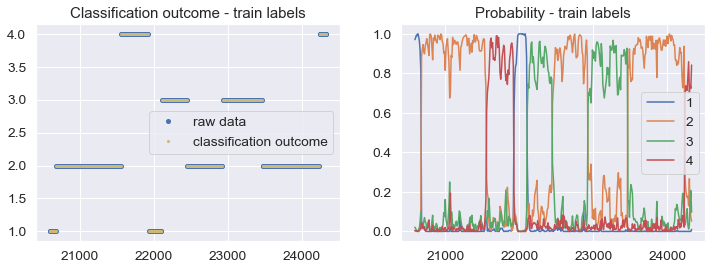

In [1765]:
#plt.plot(X_train.index,train_labels_split,'y.', label="train-train outcome")
#plt.plot(X_test.index,test_labels_split,'m.', label="train-train outcome")
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title("Classification outcome - train labels")

plt.plot(df.index,df.label,'b.', label="raw data", markersize=8)
plt.plot(df.index,train_labels,'y.', label="classification outcome",markersize=4)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Probability - train labels")

plt.plot(df.index,train_labels_proba[:,0],label=1)
plt.plot(df.index,train_labels_proba[:,1],label=2)
plt.plot(df.index,train_labels_proba[:,2],label=3)
plt.plot(df.index,train_labels_proba[:,3],label=4)

plt.legend()


Looks good! Which points are right compared to the labels povided?

In [1766]:
crosstab = pd.crosstab(np.array(train_labels), df[classification_target],
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

Predicted,1.0,2.0,3.0,4.0,All
True,,,,,
1.0,27,0,0,0,27
2.0,0,213,0,0,213
3.0,0,0,88,0,88
4.0,0,0,0,47,47
All,27,213,88,47,375


In [1767]:
print(str(100*accuracy_score(train_labels, df[classification_target]))+"% accuracy whole train data")

100.0% accuracy whole train data


Conclusions for train data: Completely right interpretation, the probability for each prediction is around 85%. Good so far. In fact the highest impact to achieve this was made by leaving out the depth for the classifier. What about the split data (remember, they are split out of the training data)?

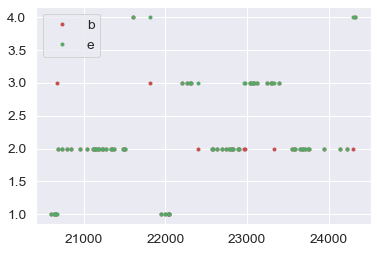

In [1768]:
plt.plot(X_test.index,test_labels_split,'r.', label='predictions')
plt.plot(X_test.index,X_test.label,'g.', label='true')
plt.legend("best")

Also looks good, but not 100%. Especially the edges seem to get misenterpreted as expected from averaging over large time windows. Let's see which labels are accurately interpreted and which not in the table:

In [1769]:
crosstab = pd.crosstab(test_labels_split, X_test[classification_target],
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab


Predicted,1.0,2.0,3.0,4.0,All
True,,,,,
1.0,9,0,0,0,9
2.0,0,44,4,1,49
3.0,1,0,13,1,15
4.0,0,0,0,2,2
All,10,44,17,4,75


Especially label=2 is likely to be misinterpreted, but we have more occurences of label 2 and additionally more edges.

Now, what is the occuacy of the classifier used on the split data:

In [1770]:
print(str(100*accuracy_score(train_labels_split, X_train[classification_target]))+"% accuracy split train data, now smaller train set")
print(str(100*accuracy_score(test_labels_split, X_test[classification_target]))+"% accuracy split train data, now test")

100.0% accuracy split train data, now smaller train set
90.66666666666666% accuracy split train data, now test


As expected, the accuracy for the train data is 100% again. Nevertheless, the prediction is not as good for the test data. But 92% still seem reasonable.

Let's look at the test data.
Next, the resulting test labels (for now), are written into df2 and displayed. 
Plot the the classification outcome (left) and the pobability for each prediction.

[4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 125


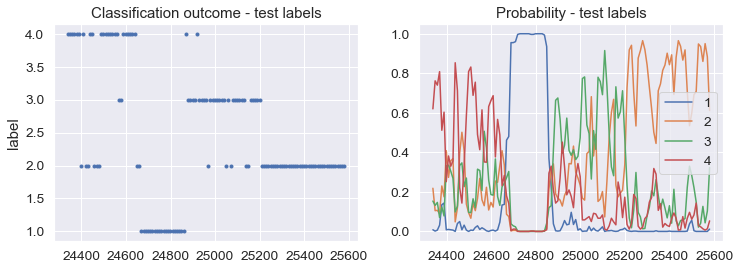

In [1771]:
df2["label"]=test_labels
#telabels["label"]=test_labels
print(list(test_labels.astype(int)), len(test_labels))
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(df2.index,test_labels,'.')
plt.title("Classification outcome - test labels")
plt.ylabel("label")
plt.subplot(1, 2, 2)
plt.title("Probability - test labels")

plt.plot(df2.index,test_labels_proba[:,0],label=1)
plt.plot(df2.index,test_labels_proba[:,1],label=2)
plt.plot(df2.index,test_labels_proba[:,2],label=3)
plt.plot(df2.index,test_labels_proba[:,3],label=4)

plt.legend()


Conclusion from plot above: A rather clear picture appears: label 4,1,3,2 follow eachother. But there are apparently misinterpreted single points. In the following, the values of neighboring labels will be given more weight. If there is a single point (also double o triple), the label will be reassigned to the majority around.

### 3.3.4 Final processing and save


In [1773]:
#backward overwriting
# find single events function
# this makes only sense for df2 (or unsplit df), as the split data ae random in index
def find_single(labels_):
    labels=list(labels_) #in order labels will not be overwritten
    for i in range(1,len(labels)-3):
        if labels[i] != labels[i-1] and labels[i]!=labels[i+1]:
            labels[i]=labels[i-1]
    # find single events (double dots)
    #for i in range(1,len(labels)):
        if labels[i] != labels[i-1] and labels[i]!=labels[i+2]:
            labels[i]=labels[i-1]
    # find single events (triple dots)
    #for i in range(1,len(labels)):
        if labels[i] != labels[i-1] and labels[i]!=labels[i+3]:
            labels[i]=labels[i-1]
    return labels
test_labels_corr=find_single(test_labels)
train_labels_corr=find_single(train_labels)



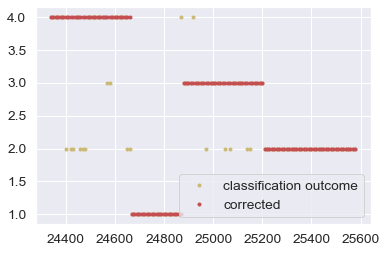

In [1778]:
plt.plot(df2.index,test_labels,'y.', label="classification outcome")
plt.plot(df2.index,test_labels_corr,'r.', label='corrected')
plt.legend()

In [1779]:
crosstab = pd.crosstab(np.array(test_labels), np.array(test_labels_corr),
                          rownames=['corrected'], colnames=['Predicted'],
                          margins=True)
crosstab

Predicted,1.0,2.0,3.0,4.0,All
corrected,,,,,
1.0,20,0,0,0,20
2.0,0,38,5,8,51
3.0,0,0,27,2,29
4.0,1,0,1,23,25
All,21,38,33,33,125


In [1780]:
np.array(test_labels_corr).astype(int)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [1781]:
# save data
df3=pd.read_csv('test_labels.csv')
df3["label"]=np.array(test_labels_corr).astype(int)
df3.to_csv("test_predict_labels.csv")



After the correction, the data seem quite reasonable. 

# 4. Conclusion

The random forest classifier was used to to classifiy smartphone accelerator data after filtering and finding adequate covariates. It was possible to achieve a classification accuracy of 85.6% with this approach compared to the real and unknown data. One possible reason for not achieving 100% is, that the test data could still be overfitted. Also the post-processing might lead to new errors. Using less covariates to avoid overfitting was checked and led to less good results on the split test data.
Probably deep learning with pattern recognition (wavelets) might enhance the accuracy a lot, but I decided to stay with the algorithms (or similar) we learned throughout the course.

### Appendix: Forest Optimizer

In [1227]:
# adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [1228]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(df[covariates_], df[classification_target])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [1229]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}